# **FLOATING OBJECT DETECTION**

**About the dataset**


1. Dataset size?
2. Size of images?
3. How many categories?
4. Exist annotation file with no data
5. Six categories: human, wind/sup-board, boat, bouy, sailboat, kayak


**[Download dataset](https://www.kaggle.com/datasets/jangsienicajzkowy/afo-aerial-dataset-of-floating-objects/data)**

In [19]:
import shutil
from pathlib import Path

**Data path**

In [20]:
# Image path of PART 1,2,3
img_path_1 = 'dataset/PART_1/PART_1/images/'
img_path_2 = 'dataset/PART_2/PART_2/images/'
img_path_3 = 'dataset/PART_3/PART_3/images/'

# Categories path
# Categories: human, wind/sup-board, boat, bouy, sailboat, kayak
categories_path = 'dataset/PART_1/PART_1/6categories/'

**Split Data into Train, Test & Validation**

In [21]:
# Split into three parts: the training (67,4% of objects), the test (19,12% of objects),
# and the validation set (13,48% of objects). In order to prevent overfitting of the model to the given data,
# the test set contains selected frames from nine videos that were not used in either the training or validation sets.

# Split image to : dataset/working/images
# Split annotation to: dataset/working/labels

def split_data(file_list, img_path, ann_path, mode):
    #Check if we have our mode folders
    images_working_folder = Path( 'dataset/working/images/'+  mode)
    if not images_working_folder.exists():
        print(f"Path {images_working_folder} does not exit")
        os.makedirs(images_working_folder)

    labels_working_folder = Path('dataset/working/labels/' + mode)
    if not labels_working_folder.exists():
        print(f"Path {labels_working_folder} does not exit")
        os.makedirs(labels_working_folder)

    #Creates the name of our label file from the img name and creates our source file
    for file in file_list:
        name = file.replace('.jpg', '')
        img_src_file = str(img_path) + '/' + name + '.jpg'
        annot_src_file = str(ann_path) + '/' + name + '.txt'
        
        if Path(img_src_file).exists() and Path(annot_src_file).exists():
            #move image
            IMG_DIR = 'dataset/working/images/' + mode
            img_dest_file = str(IMG_DIR) + '/' + name + '.jpg'
            if os.path.isfile(img_src_file) and not Path(img_dest_file).exists():
                shutil.move(img_src_file, img_dest_file)
    
            # Copy annotations
            ANNOT_DIR = 'dataset/working/labels/' + mode
            annot_dest_file = str(ANNOT_DIR) + '/' + name + '.txt'
            if os.path.isfile(annot_src_file) and not Path(annot_dest_file).exists():
                shutil.move(annot_src_file, annot_dest_file)

In [22]:
#Get our images list
train_imgs = 'dataset/PART_1/PART_1/train.txt'
test_imgs = 'dataset/PART_1/PART_1/test.txt'
val_imgs = 'dataset/PART_1/PART_1/validation.txt'
with open(train_imgs, 'r') as f:
    train_img_list = [line.strip() for line in f.readlines()]

with open(test_imgs, 'r') as f:
    test_img_list = [line.strip() for line in f.readlines()]

with open(val_imgs, 'r') as f:
    val_img_list = [line.strip() for line in f.readlines()]

print(train_img_list[0], test_img_list[0], val_img_list[0])

a_102.jpg k2_38.jpg a_101.jpg


In [23]:
# Root path
root_img_path = Path('dataset/images/')
root_ann_path = Path('dataset/annotations/')

#Split Data
split_data(train_img_list, root_img_path, root_ann_path, 'train')
split_data(test_img_list, root_img_path, root_ann_path, 'test')
split_data(val_img_list, root_img_path, root_ann_path, 'val')

In [24]:
import glob
import os
working_image_path = 'dataset/working/images/'
working_labels_path = 'dataset/working/labels/'

# Images
img_test_path = glob.glob(os.path.join(working_image_path + '/test/' , "*.jpg"))
print(f'img_test_path: {len(img_test_path)}')

img_train_path = glob.glob(os.path.join(working_image_path + '/train/' , "*.jpg"))
print(f'img_train_path: {len(img_train_path)}')

img_val_path = glob.glob(os.path.join(working_image_path + '/val/' , "*.jpg"))
print(f'img_val_path: {len(img_val_path)}')

# Labels
label_test_path = glob.glob(os.path.join(working_labels_path + '/test/' , "*.txt"))
print(f'label_test_path: {len(label_test_path)}')

label_train_path = glob.glob(os.path.join(working_labels_path + '/train/' , "*.txt"))
print(f'label_train_path: {len(label_train_path)}')

label_val_path = glob.glob(os.path.join(working_image_path + '/val/' , "*.txt"))
print(f'label_val_path: {len(label_val_path)}')

img_test_path: 514
img_train_path: 2787
img_val_path: 339
label_test_path: 514
label_train_path: 2787
label_val_path: 0


### **Train model**

In [45]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

class CustomObjectDetector:
    def __init__(self, n_components=50, n_clusters=20, sliding_window_sizes=[(100, 100), (150, 150), (200, 200)], 
                 window_step=50, confidence_threshold=0.8):
        """
        Initialize the custom object detector.
        
        Args:
            n_components: Number of PCA components
            n_clusters: Number of clusters for feature detection
            sliding_window_sizes: List of window sizes for sliding window detection
            window_step: Step size for sliding window
            confidence_threshold: Threshold for detection confidence
        """
        self.n_components = n_components
        self.n_clusters = n_clusters
        self.sliding_window_sizes = sliding_window_sizes
        self.window_step = window_step
        self.confidence_threshold = confidence_threshold
        
        # Initialize the models
        self.pca = PCA(n_components=n_components)
        self.kmeans = KMeans(n_clusters=n_clusters)
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Class names for visualization
        self.class_names = ['human', 'wind/sup-board', 'boat', 'buoy', 'sailboat', 'kayak']
        
        # Colors for visualization (one for each class)
        self.colors = [
            (0, 255, 0),    # Green for human
            (255, 0, 0),    # Blue for wind/sup-board
            (0, 0, 255),    # Red for boat
            (255, 255, 0),  # Cyan for buoy
            (255, 0, 255),  # Magenta for sailboat
            (0, 255, 255)   # Yellow for kayak
        ]
    
    def train(self, image_folder, annotation_folder):
        """
        Train the object detector.
        
        Args:
            image_folder: Path to the image folder
            annotation_folder: Path to the annotation folder
        """
        print("Loading training data...")
        X_train, y_train, _, _ = self.load_dataset(image_folder, annotation_folder, 'train', debug_visualization=False)
        
        if len(X_train) == 0:
            raise ValueError("No training data found. Check your paths and data format.")

        print(f"Loaded {len(X_train)} training samples")

        # Apply PCA for dimensionality reduction
        print("Applying PCA...")
        X_train_pca = self.pca.fit_transform(X_train)

        # Train k-means for feature clustering
        print("Training K-means clustering...")
        self.kmeans.fit(X_train_pca)

        # Add cluster information to features
        cluster_features = self.kmeans.transform(X_train_pca)
        X_train_with_clusters = np.hstack([X_train_pca, cluster_features])

        # Train the classifier
        print("Training the classifier...")
        self.classifier.fit(X_train_with_clusters, y_train)

        # Evaluate on validation set if available
        try:
            print("Evaluating on test data...")
            # X_val, y_val, _, _ = self.load_dataset(image_folder, annotation_folder, 'val')
            X_test, y_test, _, _ = self.load_dataset(image_folder, annotation_folder, 'test')
            if len(X_test) > 0:
                X_test_pca = self.pca.transform(X_test)
                cluster_test = self.kmeans.transform(X_test_pca)
                X_test_with_clusters = np.hstack([X_test_pca, cluster_test])
                y_pred = self.classifier.predict(X_test_with_clusters)
                print("Test accuracy:", accuracy_score(y_test, y_pred))
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred, target_names=self.class_names))
        except Exception as e:
            print(f"Could not evaluate on validation data: {e}")
    
    
    def train_with_background(self, image_folder, annotation_folder):
        """
        Train classifier with an explicit background class to improve discrimination.
        This is an advanced enhancement that requires creating negative samples.
        
        Args:
            image_folder: Path to the image folder
            annotation_folder: Path to the annotation folder
        """
        print("Loading training data...")
        X_train, y_train, _, _ = self.load_dataset(image_folder, annotation_folder, 'train')
        
        # Get hard negative examples (background images that might confuse the classifier)
        print("Mining hard negative examples...")
        X_hard_neg, y_hard_neg = self.mine_hard_negatives(image_folder, annotation_folder)
        
        # Combine regular training data with hard negatives
        X_combined = np.vstack([X_train, X_hard_neg]) if len(X_hard_neg) > 0 else X_train
        y_combined = np.concatenate([y_train, y_hard_neg]) if len(y_hard_neg) > 0 else y_train
        
        print(f"Training with {len(X_train)} regular examples and {len(X_hard_neg) if len(X_hard_neg) > 0 else 0} hard negative examples")
        
        # Apply PCA for dimensionality reduction
        print("Applying PCA...")
        X_train_pca = self.pca.fit_transform(X_combined)
        
        # Train k-means for feature clustering
        print("Training K-means clustering...")
        self.kmeans.fit(X_train_pca)
        
        # Add cluster information to features
        cluster_features = self.kmeans.transform(X_train_pca)
        X_train_with_clusters = np.hstack([X_train_pca, cluster_features])
        
        # Train the classifier
        print("Training the classifier with background class...")
        self.classifier.fit(X_train_with_clusters, y_combined)
        
        
    
    def load_dataset(self, image_folder, annotation_folder, split_type='train', debug_visualization=False):
        """
        Load the dataset.
        
        Args:
            image_folder: Path to the image folder
            annotation_folder: Path to the annotation folder
            split_type: 'train', 'test', or 'val'
            
        Returns:
            X: Features
            y: Labels
            bbox_data: Bounding box information
            image_paths: Paths to the images
        """
        print("Loading dataset...")
        X = []
        y = []
        bbox_data = []
        image_paths = []
        
        img_dir = os.path.join(image_folder, split_type)
        ann_dir = os.path.join(annotation_folder, split_type)
        
        image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
        for img_file in tqdm(image_files):
            # Get the corresponding annotation file
            ann_file = os.path.splitext(img_file)[0] + '.txt'
            ann_path = os.path.join(ann_dir, ann_file)
            
            # Skip if annotation file doesn't exist
            if not os.path.exists(ann_path):
                continue
            
            # Load image
            img_path = os.path.join(img_dir, img_file)
            image = cv2.imread(img_path)
            
            if image is None:
                print(f"Warning: Could not read image {img_path}")
                continue
            
            image_height, image_width = image.shape[:2]
            image_paths.append(img_path)
            # print(f'Image path: {img_path}')
            
            # Read annotations
            with open(ann_path, 'r') as f:
                lines = f.readlines()
            
            # Process each object in the image
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                    
                class_id = int(parts[0])
                # YOLO format: center_x, center_y, width, height (normalized)
                x_center = float(parts[1]) * image_width
                y_center = float(parts[2]) * image_height
                width = float(parts[3]) * image_width
                height = float(parts[4]) * image_height

                # Convert to top-left, bottom-right coordinates
                x1 = max(0, int(x_center - width / 2))
                y1 = max(0, int(y_center - height / 2))
                x2 = min(image_width, int(x_center + width / 2))
                y2 = min(image_height, int(y_center + height / 2))
                # x1 = float(image_width) * (2.0 * float(parts[1]) - float(parts[3])) / 2.0
                # y1 = float(image_height) * (2.0 * float(parts[2]) - float(parts[4])) / 2.0
                # x2 = float(image_width) * (2.0 * float(parts[1]) + float(parts[3])) / 2.0
                # y2 = float(image_height) * (2.0 * float(parts[2]) + float(parts[4])) / 2.0

                # Extract the object region (ROI)
                object_img = image[int(y1):int(y2), int(x1):int(x2)]
                
                # Extract features
                features = self.extract_features(object_img)
                X.append(features)
                y.append(class_id)
                bbox_data.append((img_path, class_id, int(x1), int(y1), int(x2), int(y2)))
                
                # Extract the object region with error handling
                try:
                    # Visual debugging if requested
                    if debug_visualization:
                        plt.figure(figsize=(10, 5))
                        plt.subplot(1, 2, 1)
                        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-')
                        plt.title(f"Image with box: {self.class_names[class_id]}")
                        
                        plt.subplot(1, 2, 2)
                        plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB))
                        plt.title(f"Extracted region: {self.class_names[class_id]}")
                        
                        plt.tight_layout()
                        plt.show()
                except Exception as e:
                    print(f"Error processing region in {img_path}: {e}")
                    continue
                
                
        return np.array(X), np.array(y), bbox_data, image_paths
    
    def extract_features(self, image):
        """
        Extract features from an image.
        
        Args:
            image: Input image
            
        Returns:
            features: Extracted features
        """
        # Convert to grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Resize to a standard size
        resized = cv2.resize(gray, (100, 100))
        
        # Apply some basic features (without using pre-built model)
        # 1. Histogram of oriented gradients (simplified)
        gx = cv2.Sobel(resized, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(resized, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        
        # 2. Intensity histogram
        hist = cv2.calcHist([resized], [0], None, [32], [0, 256])
        
        # 3. Local binary patterns (simplified)
        lbp = np.zeros_like(resized)
        for i in range(1, resized.shape[0] - 1):
            for j in range(1, resized.shape[1] - 1):
                center = resized[i, j]
                code = 0
                code |= (resized[i-1, j-1] >= center) << 0
                code |= (resized[i-1, j] >= center) << 1
                code |= (resized[i-1, j+1] >= center) << 2
                code |= (resized[i, j+1] >= center) << 3
                code |= (resized[i+1, j+1] >= center) << 4
                code |= (resized[i+1, j] >= center) << 5
                code |= (resized[i+1, j-1] >= center) << 6
                code |= (resized[i, j-1] >= center) << 7
                lbp[i, j] = code
        
        lbp_hist = cv2.calcHist([lbp.astype(np.uint8)], [0], None, [32], [0, 256])
        
        # Concatenate all features
        features = np.concatenate([
            mag.flatten(),
            ang.flatten(),
            hist.flatten(),
            lbp_hist.flatten()
        ])
        
        return features
    
    
    def mine_hard_negatives(self, image_folder, annotation_folder, num_images=5):
        """
        Find difficult negative examples to improve classifier discrimination.
        This finds background regions that the current classifier might mistake for objects.
        
        Args:
            image_folder: Path to the image folder
            annotation_folder: Path to the annotation folder
            num_images: Number of images to process
            
        Returns:
            X_hard_negatives: Features of hard negative examples
            y_hard_negatives: Labels for hard negative examples (background class)
        """
        X_hard_negatives = []
        y_hard_negatives = []  # All will be class 6 (background)
        
        # Process training images
        img_dir = os.path.join(image_folder, 'train')
        image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Limit number of images to process
        image_files = image_files[:num_images]
        
        for img_file in image_files:
            img_path = os.path.join(img_dir, img_file)
            image = cv2.imread(img_path)
            
            if image is None:
                continue
                
            image_height, image_width = image.shape[:2]
            
            # Get ground truth boxes
            ann_file = os.path.splitext(img_file)[0] + '.txt'
            ann_path = os.path.join(annotation_folder, 'train', ann_file)
            
            gt_boxes = []
            if os.path.exists(ann_path):
                with open(ann_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) < 5:
                            continue
                        
                        class_id = int(parts[0])
                        x_center = float(parts[1]) * image_width
                        y_center = float(parts[2]) * image_height
                        width = float(parts[3]) * image_width
                        height = float(parts[4]) * image_height
                        
                        x1 = max(0, int(x_center - width / 2))
                        y1 = max(0, int(y_center - height / 2))
                        x2 = min(image_width, int(x_center + width / 2))
                        y2 = min(image_height, int(y_center + height / 2))
                        
                        gt_boxes.append((class_id, x1, y1, x2, y2))
            
            # Randomly sample windows that don't overlap with ground truth
            num_negative_samples = 20  # Number of negative samples per image
            attempts = 0
            samples_found = 0
            
            while samples_found < num_negative_samples and attempts < 100:
                attempts += 1
                
                # Choose a random window size
                window_size = self.sliding_window_sizes[np.random.randint(0, len(self.sliding_window_sizes))]
                
                # Choose a random position
                x = np.random.randint(0, max(1, image_width - window_size[0]))
                y = np.random.randint(0, max(1, image_height - window_size[1]))
                
                # Check overlap with ground truth boxes
                window_rect = (x, y, x + window_size[0], y + window_size[1])
                is_background = True
                
                for gt in gt_boxes:
                    _, gt_x1, gt_y1, gt_x2, gt_y2 = gt
                    
                    # Calculate IoU
                    x_overlap = max(0, min(window_rect[2], gt_x2) - max(window_rect[0], gt_x1))
                    y_overlap = max(0, min(window_rect[3], gt_y2) - max(window_rect[1], gt_y1))
                    overlap_area = x_overlap * y_overlap
                    
                    if overlap_area > 0:
                        window_area = (window_rect[2] - window_rect[0]) * (window_rect[3] - window_rect[1])
                        gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
                        
                        iou = overlap_area / float(window_area + gt_area - overlap_area)
                        
                        if iou > 0.1:  # If significant overlap, this is not a true background
                            is_background = False
                            break
                
                # If this is a true background region, extract features
                if is_background:
                    try:
                        # Extract the window
                        window = image[y:y+window_size[1], x:x+window_size[0]]
                        
                        # Check if window is valid
                        if window is None or window.size == 0 or window.shape[0] <= 0 or window.shape[1] <= 0:
                            continue
                        
                        # Extract features
                        features = self.extract_features(window)
                        
                        # Use current model to see if this window would be misclassified
                        features_reshaped = features.reshape(1, -1)
                        
                        try:
                            features_pca = self.pca.transform(features_reshaped)
                            cluster_features = self.kmeans.transform(features_pca)
                            features_with_clusters = np.hstack([features_pca, cluster_features])
                            
                            # If classifier is already trained, check if this would be a hard negative
                            if hasattr(self.classifier, 'classes_'):
                                confidence = np.max(self.classifier.predict_proba(features_with_clusters)[0])
                                
                                # If confidence is medium-high, this is a good hard negative example
                                if confidence > 0.3:
                                    X_hard_negatives.append(features)
                                    y_hard_negatives.append(6)  # Background class = 6
                                    samples_found += 1
                            else:
                                # If classifier isn't trained yet, just add as negative
                                X_hard_negatives.append(features)
                                y_hard_negatives.append(6)  # Background class = 6
                                samples_found += 1
                                
                        except Exception as e:
                            continue
                    except Exception as e:
                        continue
        
        # Convert to numpy arrays if we found any samples
        if len(X_hard_negatives) > 0:
            return np.array(X_hard_negatives), np.array(y_hard_negatives)
        else:
            return np.array([]), np.array([])
    
    
    def save_model(self, model_path):
        """
        Save the trained model.
        
        Args:
            model_path: Path to save the model
        """
        model_data = {
            'pca': self.pca,
            'kmeans': self.kmeans,
            'classifier': self.classifier,
            'n_components': self.n_components,
            'n_clusters': self.n_clusters,
            'class_names': self.class_names,
            'colors': self.colors,
            'confidence_threshold': self.confidence_threshold,
            'window_step': self.window_step
        }
        
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved to {model_path}")
            
    def detect_objects(self, image):
        """
        Detect objects in a single image with improved filtering.
        
        Args:
            image: Input image
            
        Returns:
            detections: List of (class_id, confidence, x1, y1, x2, y2)
        """
        detections = []
        
        # Sliding window detection
        for window_size in self.sliding_window_sizes:
            for y in range(0, image.shape[0] - window_size[1], self.window_step):
                for x in range(0, image.shape[1] - window_size[0], self.window_step):
                    # Extract window
                    window = image[y:y+window_size[1], x:x+window_size[0]]
                    
                    # Skip small or invalid windows
                    if window is None or window.size == 0 or window.shape[0] <= 0 or window.shape[1] <= 0:
                        continue
                    
                    # Extract features from the window
                    try:
                        features = self.extract_features(window)
                        features = features.reshape(1, -1)
                        
                        # Apply PCA
                        features_pca = self.pca.transform(features)
                        
                        # Get cluster features
                        cluster_features = self.kmeans.transform(features_pca)
                        features_with_clusters = np.hstack([features_pca, cluster_features])
                        
                        # Predict class and confidence
                        class_id = self.classifier.predict(features_with_clusters)[0]
                        confidence = np.max(self.classifier.predict_proba(features_with_clusters)[0])
                        
                        # CHANGE 3: Only keep high-confidence detections
                        if confidence > self.confidence_threshold:
                            detections.append((class_id, confidence, x, y, x+window_size[0], y+window_size[1]))
                    except Exception as e:
                        continue
        
        # Apply non-maximum suppression to remove overlapping boxes
        # CHANGE 4: Using stricter NMS with higher overlap threshold
        detections = self.non_max_suppression(detections, 0.5)  # Changed from 0.3 to 0.5
        
        return detections
    
    def non_max_suppression(self, boxes, overlap_thresh=0.5):
        """
        Apply non-maximum suppression to remove overlapping detections.
        Enhanced to better handle multiple detections of the same object.
        
        Args:
            boxes: List of (class_id, confidence, x1, y1, x2, y2)
            overlap_thresh: Threshold for overlap (increased to remove more duplicates)
            
        Returns:
            result: List of non-overlapping boxes
        """
        # If no boxes, return empty list
        if len(boxes) == 0:
            return []
        
        # Convert to numpy array
        boxes = np.array(boxes)
        
        # Initialize the list of picked indexes
        pick = []
        
        # Extract coordinates
        class_ids = boxes[:, 0]
        confidences = boxes[:, 1]
        x1 = boxes[:, 2]
        y1 = boxes[:, 3]
        x2 = boxes[:, 4]
        y2 = boxes[:, 5]
        
        # Compute area of the boxes
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        
        # Sort by confidence (highest first)
        idxs = np.argsort(confidences)[::-1]
        
        # Keep looping while some indexes still remain in the indexes list
        while len(idxs) > 0:
            # Grab the last index and add the index value to the list of picked indexes
            last = len(idxs) - 1
            i = idxs[0]
            pick.append(i)
            
            # Find the largest (x, y) coordinates for the start of the bounding box
            # and the smallest (x, y) coordinates for the end of the bounding box
            xx1 = np.maximum(x1[i], x1[idxs[1:]])
            yy1 = np.maximum(y1[i], y1[idxs[1:]])
            xx2 = np.minimum(x2[i], x2[idxs[1:]])
            yy2 = np.minimum(y2[i], y2[idxs[1:]])
            
            # Compute the width and height of the bounding box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
            
            # Compute the ratio of overlap
            overlap = (w * h) / area[idxs[1:]]
            
            # Delete all indexes from the index list that have overlap greater than the threshold
            idxs = np.delete(idxs, np.concatenate(([0], np.where(overlap > overlap_thresh)[0] + 1)))
        
        # Return only the bounding boxes that were picked
        result = [boxes[i] for i in pick]
        return result
    
    def visualize_detection(self, image, detections):
        """
        Visualize detection results with improved labeling.
        
        Args:
            image: Input image
            detections: List of (class_id, confidence, x1, y1, x2, y2)
            
        Returns:
            result_image: Image with detections
        """
        result_image = image.copy()
        
        # Sort detections by confidence (highest first) for better visualization
        sorted_detections = sorted(detections, key=lambda x: x[1], reverse=True)
        
        for detection in sorted_detections:
            class_id, confidence, x1, y1, x2, y2 = detection
            class_id = int(class_id)
            
            # Draw bounding box with thicker lines for visibility
            color = self.colors[class_id]
            cv2.rectangle(result_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
            
            # Create label with class name and confidence
            label = f"{self.class_names[class_id]}: {confidence:.2f}"
            
            # Get text size for better label placement
            (label_width, label_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2
            )
            
            # Draw label background
            cv2.rectangle(
                result_image, 
                (int(x1), int(y1) - label_height - 10), 
                (int(x1) + label_width, int(y1)), 
                color, 
                -1  # Filled rectangle
            )
            
            # Draw label text in white for better visibility
            cv2.putText(
                result_image, 
                label, 
                (int(x1), int(y1) - 7),
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.7, 
                (255, 255, 255), 
                2
            )
        
        # Add metadata about the detection
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        info_text = f"Detections: {len(detections)} | Time: {timestamp} | Confidence threshold: {self.confidence_threshold}"
        cv2.putText(
            result_image,
            info_text,
            (10, result_image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 0),
            2
        )
        
        return result_image
    

In [43]:
def load_model(model_path):
        """
        Load a trained model.
        
        Args:
            model_path: Path to the model
            
        Returns:
            detector: Loaded detector
        """
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        
        detector = CustomObjectDetector(
            n_components=model_data['n_components'],
            n_clusters=model_data['n_clusters'],
            confidence_threshold=model_data['confidence_threshold'],
            window_step=model_data.get('window_step', 50)  # Default to 50 if not in saved model
        )
        
        detector.pca = model_data['pca']
        detector.kmeans = model_data['kmeans']
        detector.classifier = model_data['classifier']
        detector.class_names = model_data['class_names']
        detector.colors = model_data['colors']
        
        print(f"Model loaded from {model_path}")
        print(f"Using confidence threshold: {detector.confidence_threshold}")
        print(f"Using window step size: {detector.window_step}")
        
        return detector

In [46]:
# Define paths
image_folder = 'dataset/working/images'  # Base folder containing train, test, val
annotation_folder = 'dataset/working/labels'  # Base folder containing train, test, val
model_path = 'custom_detector1.pkl'

# Create and train the detector
detector = CustomObjectDetector()
detector.train(image_folder, annotation_folder)

# Option 2: Advanced training with background class (uncomment to use)
# detector.train_with_background(image_folder, annotation_folder)

# Save the model
detector.save_model(model_path)

Loading training data...
Loading dataset...


100%|██████████| 2787/2787 [29:10<00:00,  1.59it/s]  


Mining hard negative examples...
Training with 26960 regular examples and 0 hard negative examples
Applying PCA...
Training K-means clustering...
Training the classifier with background class...
Model saved to custom_detector1.pkl


Model loaded from custom_detector1.pkl
Using confidence threshold: 0.8
Using window step size: 50


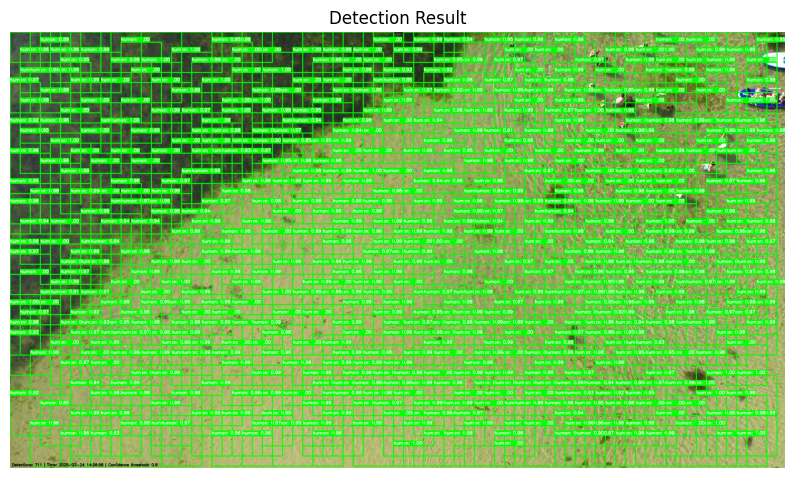

In [47]:
loaded_detector = load_model(model_path)
saved_path = 'det2.jpg'

# Test on a single image
test_image = cv2.imread('dataset/working/images/val/a_101.jpg')
detections = loaded_detector.detect_objects(test_image)
result_image = loaded_detector.visualize_detection(test_image, detections)
cv2.imwrite(saved_path, result_image)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Detection Result')
plt.axis('off')
plt.savefig('detection_result.jpg')
plt.show()